# Code

In [19]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
from plot_setup import * 
import MCgenerator, dSph_model, coord
from numpy import power,sqrt
from scipy.stats import norm

In [21]:
%autoreload 2

In [22]:
dSph_property = pd.read_csv("dSph_property.csv",index_col=0)
draco_prop = dSph_property.loc["Draco"]
RA0 = draco_prop.RAdeg
DE0 = draco_prop.DEdeg
DIST = draco_prop.DIST
dSph_property

,RAh,RAm,RAs,pmDEd,DEm,DEs,DIST,HLR,RAdeg,DEdeg
Draco,17,20,12,57,54,55,76000.0,221.0,260.05,57.915278


In [23]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-3000pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
# v001: for mycut
# v002: for spectroscopy cut

## definition of likelihood

In [24]:
class KI17_loglikelihood_mod_cont:
    def __init__(self,vs,beta=1):
        self.vs = vs
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args))
    
    def is_parameters_in_domain(self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 < vfg1 < vfg2
        is_ffg_normalized_ = 0<=sfg0<=1 and 0<=sfg1<=1 and (sfg0+sfg1)<=1
        is_not_fast = np.all(np.abs(np.array([vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2]))<3e8)
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_not_fast)
    
    def loglikelis(
        self,
            vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            sfg2 = 1-sfg0-sfg1
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(ffg)

            return self.beta * ret
        
    def fit_plot(self,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1,bins=64,**kwargs):
        fig,ax = plt.subplots(1,1)
        vs=self.vs
        sfg2 = 1-sfg0-sfg1 
        ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
        ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
        ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
        ffg = ffg0+ffg1+ffg2
        df = pd.DataFrame()
        df[r"$v$"] = vs
        df["$f_{FG,0}$"] = ffg0
        df["$f_{FG,1}$"] = ffg1
        df["$f_{FG,2}$"] = ffg2
        df["$f_{FG,tot}$"] = ffg
        
        df = df.sort_values(r"$v$")
        
        ax.hist(vs,density=True,bins=bins)
        df.plot(x=r"$v$",ax=ax,**kwargs)


In [25]:
#update likelihood
def is_positive(*args):
    return np.array(args)>0

class KI17_loglikelihood_mod:
    def __init__(self,vs,dRAs,dDEs,beta=1):
        self.vs = vs
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        #print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        mem = dSph_model.plummer_model(re_pc=200)
        dm = dSph_model.NFW_model(a=2.78,b=7.78,g=0.675,rhos_Msunpc3=np.power(10,-2.05),rs_pc=np.power(10,3.96),R_trunc_pc=2000)
        self.dsph = dSph_model.dSph_model(anib=-0.5,submodels_dict={"stellar_model":mem,"DM_model":dm},show_init=True)
        
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R,show_init=True)


    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")

    def logprior(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        
        G_re = norm.pdf(re,loc=191,scale=5.7)
        #G_odds = norm.pdf(odds,loc=8.794,scale=0.5107)
        G_dra0 = norm.pdf(dra0,loc=4.212e-3,scale=7.052e-3)
        G_dde0 = norm.pdf(dde0,loc=-1.991e-3,scale=3.302e-3)
        
        return np.sum(np.log([G_re,G_dra0,G_dde0]))
    
    def __call__(self,**args):
        return np.sum(self.loglikelis(**args)) + self.logprior(**args)
    
    def is_parameters_in_domain(self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
        is_positive_ = np.all(is_positive(re,odds,dvfg0,dvfg1,dvfg2))
        is_vfg_ordered_ = vfg0 <= vfg1 <= vfg2
        is_ffg_normalized_ = 0<=sfg0<=1 and 0<=sfg1<=1 and (sfg0+sfg1)<=1
        is_in_domain_ = -1<mlog10_1manib<1 and -4<log10_rhos_Msunpc3<4 and 0<log10_rs_pc<5 and 0.5<a<3 and 3<b<10 and 0<g<1.2
        is_not_fast = np.all(np.abs(np.array([vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2]))<3e8)
        return (is_positive_ and is_vfg_ordered_ and is_ffg_normalized_ and is_in_domain_ and is_not_fast)
    
    def loglikelis(
        self,re,odds,dra0,dde0,
            log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
            mlog10_1manib,
            vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1
    ): # R_trunc_pc is fixed 2000 pc
        if not self.is_parameters_in_domain(re,odds,dra0,dde0,
                log10_rs_pc,log10_rhos_Msunpc3,a,b,g,
                mlog10_1manib,
                vmem,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2, sfg0, sfg1):
            return -np.inf
        else:
            vs=self.vs
            mem,dm,fg = self.dsph.submodels["stellar_model"],self.dsph.submodels["DM_model"],self.fg
            mem.update({"re_pc":re})
            dm.update({"rs_pc":power(10,log10_rs_pc),"rhos_Msunpc3":power(10,log10_rhos_Msunpc3),"a":a,"b":b,"g":g})
            self.dsph.update({"anib":1-power(10,-mlog10_1manib)})
            ref_R = mem.half_light_radius() # 1.67834699001666*re
            
            Rs = self.Rs(dra0,dde0)
        
            s = 1/(1+ 1/(odds * mem.density_2d_normalized_re(Rs)))
            sigmalos2 = self.dsph.sigmalos2_interp1d(Rs,step_inner=8,step_outer=16)
            sfg2 = 1-sfg0-sfg1
            
            fmem = norm.pdf(vs,loc=vmem,scale=sqrt(sigmalos2))
            
            ffg0 = sfg0 * norm.pdf(vs,loc=vfg0,scale=dvfg0)
            ffg1 = sfg1 * norm.pdf(vs,loc=vfg1,scale=dvfg1)
            ffg2 = sfg2 * norm.pdf(vs,loc=vfg2,scale=dvfg2)
            ffg = ffg0+ffg1+ffg2
            
            ret = np.log(s*fmem+(1-s)*ffg)

            return self.beta * ret


Text(0,0.5,'$y$[deg]')

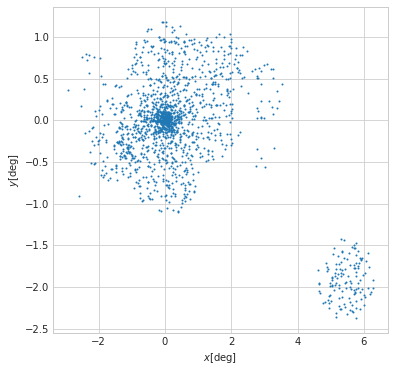

In [26]:
df0 = pd.read_csv("dra_sspp2_RADEdeg.csv")
#display(df0)
df_deg = pd.DataFrame(df0[["RAdeg","DEdeg"]])
df_rad = np.deg2rad(pd.DataFrame(df_deg))

df_deg["x"] = df_deg["RAdeg"] - RA0
df_deg["y"] = df_deg["DEdeg"] - DE0

#ra = coord.hms_to_deg(df.RAh,df.RAm,df.RAs) + ra0
#de = coord.dms_to_deg(df.pmDEd,df.DEm,df.DEs) + de0
ra = df_deg.RAdeg
de = df_deg.DEdeg
vs = df0.Vlos

arg_proj_dist = {
    "ra":ra,"de":de,
    "ra_center":RA0,"de_center":DE0
}
angles = coord.projected_angle(**arg_proj_dist,dtype="deg")
Rs = coord.projected_distance(dist=DIST,**arg_proj_dist,dtype="deg")
distort = np.cos(np.deg2rad(draco_prop.DEdeg))
deg_max = 4
df_deg[(np.abs(df_deg.x)<deg_max/distort).values * (np.abs(df_deg.y)<deg_max).values].plot.scatter("x","y",s=1,figsize=(6,6))
plt.xlabel(r"$x$[deg]")
plt.ylabel(r"$y$[deg]")

## density of ofserbed stars

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78c25df9b0>]],
      dtype=object)

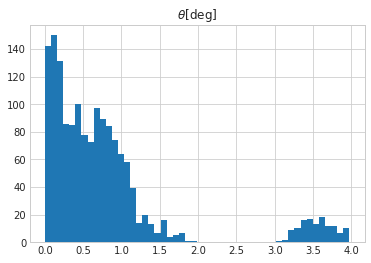

In [8]:
pd.DataFrame({r"$\theta$[deg]":angles}).hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f78ba6866a0>]],
      dtype=object)

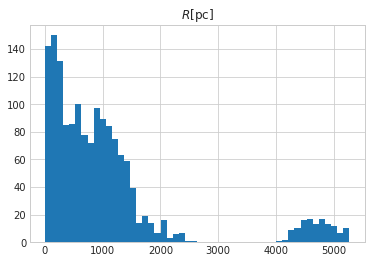

In [9]:
pd.DataFrame({r"$R$[pc]":Rs}).hist(bins=50)

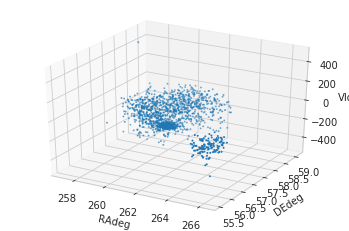

In [10]:
df0[["RAdeg","DEdeg","Vlos"]].plot_scatter3D("RAdeg","DEdeg","Vlos",s=1)

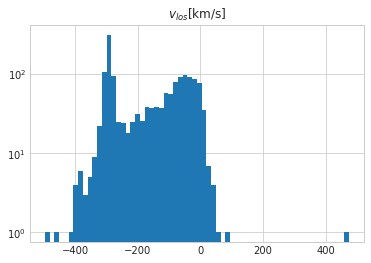

In [334]:
df_vlos = pd.DataFrame({r"$v_{los}$[km/s]":df0.Vlos.values})
df_vlos.hist(bins=64)
len(df0)
plt.yscale("log")

730

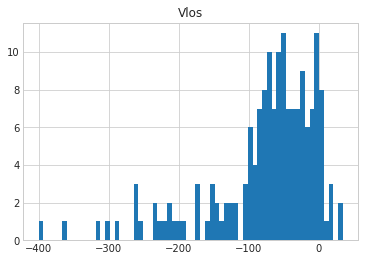

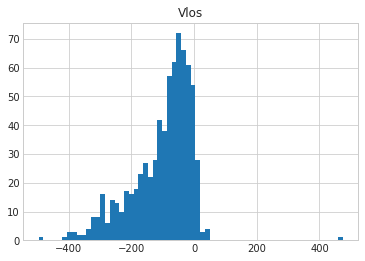

In [15]:
df_plot = df0[Rs>830]
df0[Rs>1900].hist("Vlos",bins=64)
df0[Rs>830].hist("Vlos",bins=64)
len(df_plot)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7878324e48>]],
      dtype=object)

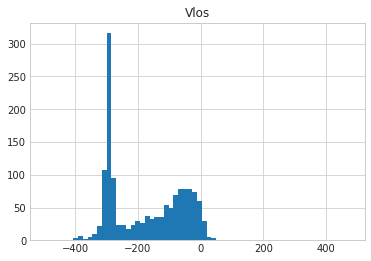

In [115]:
df0[angles<2.5].hist("Vlos",bins=64)

## likelihood compile

In [27]:
isin_sig = Rs<3000 #830(95%), 1900(99%), 3000
loglikeli_cont =  KI17_loglikelihood_mod_cont(vs=vs[np.logical_not(isin_sig)])
loglikeli = KI17_loglikelihood_mod(vs=vs[isin_sig],dRAs=df_deg.x[isin_sig],dDEs=df_deg.y[isin_sig])
#sigmalos2 = loglikeli.dsph.sigmalos2_using_mykernel(loglikeli.Rs(0,0))
#loglikeli = KI17_loglikelihood(Rs[angles<1.0])

initialized:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64
initialized:
Rmax_pc    2531.745788
dtype: float64


CPU times: user 1.9 s, sys: 0 ns, total: 1.9 s
Wall time: 1.91 s


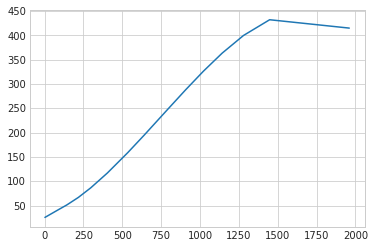

In [28]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::100]
ys0 = loglikeli.dsph.sigmalos2(R_pc)
plt.plot(R_pc,ys0)

: Plummer model and NFW model:
re_pc            200.000000
a                  2.780000
b                  7.780000
g                  0.675000
rhos_Msunpc3       0.008913
rs_pc           9120.108394
R_trunc_pc      2000.000000
dtype: float64

2000.0

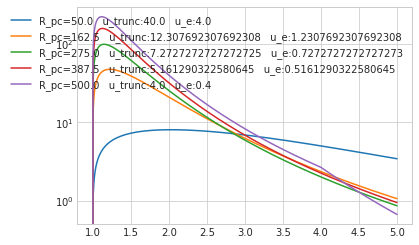

In [13]:
display(loglikeli.dsph)
us = np.linspace(1,5,1000)
for R_pc in np.linspace(50,500,5):#,100,200,1000,2000,3000,4000):
    ys = loglikeli.dsph.integrand_sigmalos2_using_mykernel(arg_R_pc=R_pc,u=us)
    R_trunc_pc= loglikeli.dsph.submodels["DM_model"].params.R_trunc_pc
    re_pc= loglikeli.dsph.submodels["stellar_model"].params.re_pc
    plt.plot(us,ys,label="R_pc="+str(R_pc)+"   u_trunc:"+str(R_trunc_pc/R_pc)+"   u_e:"+str(re_pc/R_pc))
    #display(ys)
plt.legend()
plt.xscale("linear")
plt.yscale("log")
display(R_trunc_pc)

CPU times: user 1.18 s, sys: 0 ns, total: 1.18 s
Wall time: 1.18 s


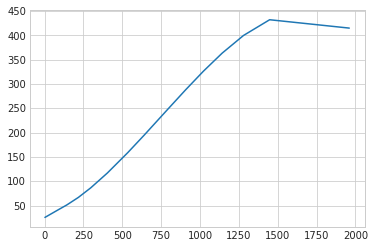

In [14]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::100]
ys1 = loglikeli.dsph.sigmalos2_using_mykernel(R_pc)
plt.plot(R_pc,ys1)

CPU times: user 48 ms, sys: 32 ms, total: 80 ms
Wall time: 12.7 s


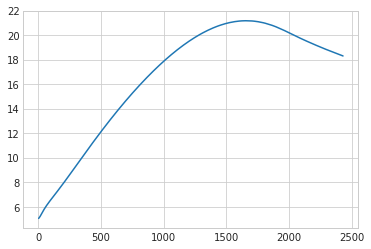

In [55]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::4]
ys0 = loglikeli.dsph.sigmalos2_multi_using_mykernel(R_pc)
plt.plot(R_pc,sqrt(ys0))

CPU times: user 28 ms, sys: 32 ms, total: 60 ms
Wall time: 772 ms


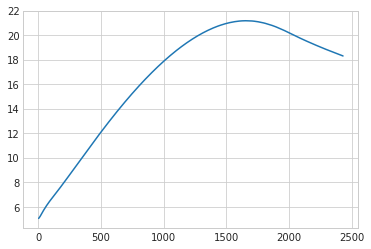

In [53]:
%%time
R_pc = np.sort(loglikeli.Rs(0,0))[::4]
ys1 = loglikeli.dsph.sigmalos2_interp1d(
    R_pc,step_before_Rtrunc=4,step_center=2,step_inner=4,step_around_Rtrunc=4,step_outer=4,kind="cubic")
plt.plot(R_pc,sqrt(ys1))

1.6773225331654775

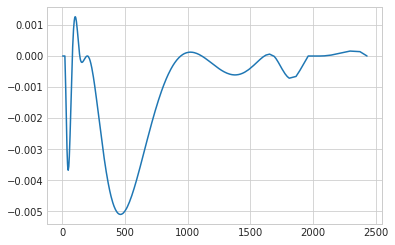

In [51]:
plt.plot(R_pc,(np.array(ys1)-np.array(ys0))/np.array(ys0))
min(R_pc)

# MCMC

## Cont

In [400]:
gen_cont = MCgenerator.MCgenerator(
    args_logpdf_init={
        "vfg0": -152.939605,
        "vfg1": -43.608103,
        "vfg2": -4.512821,
        "dvfg0": 80.441576,
        "dvfg1": 33.495326,
        "dvfg2": 0.490637,
        "sfg0":  0.183776,
        "sfg1":  0.773582},
#    args_logpdf_init={
#        'vfg0':-136, 'vfg1':-46, 'vfg2':-5, 'dvfg0':93, 'dvfg1':32,'dvfg2':0.6,
#        'sfg0':0.25,'sfg1':0.66
#    },
    dargs_logpdf={
        'vfg0':30, 'vfg1':8, 'vfg2':0.001, 'dvfg0':15, 'dvfg1':6,'dvfg2':0.001,
        'sfg0':0.05,'sfg1':0.05
    },
    logpdf_func=loglikeli_cont
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [246]:
loglikeli_cont(**{
        'vfg0':-4e8, 'vfg1':-200, 'vfg2':-0, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.01,'sfg1':0.2
    })

TypeError: loglikelis() got an unexpected keyword argument 'kwargs'

In [401]:
Nstep_init = 100000
gen_cont.generate(Nstep_init)

MCgeneration start.
options: {}
24.436% completed... acceptance rate: 0.30%
47.274% completed... acceptance rate: 0.34%
72.236% completed... acceptance rate: 0.32%
96.923% completed... acceptance rate: 0.29%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
   dvfg0  dvfg1  dvfg2  sfg0  sfg1  vfg0  vfg1   vfg2  iter_num
0   15.0    6.0  0.001  0.05  0.05  30.0   8.0  0.001    100000


In [408]:
#gen_cont.generate(100000)
gen_cont.generate_tuned([100000]*3)

MCgeneration start.
options: {}
26.081% completed... acceptance rate: 6.98%
51.902% completed... acceptance rate: 7.05%
77.473% completed... acceptance rate: 7.28%
MCgeneration end.
MCresults are stored.
MCinfo are logged.
           dvfg0      dvfg1      dvfg2      sfg0      sfg1          vfg0  \
0   1.500000e+01   6.000000   0.001000  0.050000  0.050000  3.000000e+01   
1   1.500000e+01   6.000000   0.001000  0.050000  0.050000  3.000000e+01   
2   5.177831e+00   2.379660   0.003725  0.037428  0.037129  8.652807e+00   
3   4.648022e+00   2.389318   0.071137  0.037299  0.037199  9.435116e+00   
4   4.576232e+00   2.553103   3.505029  0.038840  0.044734  9.673966e+00   
5   1.453487e+02  25.733978  10.106886  0.195791  0.087779  5.813398e+01   
6   1.228543e+01   2.488837   1.971613  0.002589  0.006408  3.707344e+01   
7   2.440723e+02   5.161400   2.290701  0.003720  0.038385  3.209069e+02   
8   7.700292e+03   5.052676   2.310969  0.001959  0.040077  1.057053e+04   
9   1.263845e+05 

,vfg0,vfg1,vfg2,dvfg0,dvfg1,dvfg2,sfg0,sfg1,logpdf
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-495.920174,-182.695385,-47.667961,691.291577,90.771721,37.964719,0.004839,0.402315,-4234.994501
std,320.908460,10.578984,2.933816,244.070625,5.161461,2.290699,0.003720,0.038385,1.920578
min,-1925.382953,-225.336566,-59.556910,157.505407,70.384634,28.691417,0.000007,0.276553,-4246.091683
25%,-624.984269,-189.514808,-49.657198,505.700084,87.380581,36.425104,0.002231,0.376847,-4236.027665
50%,-383.859565,-182.472972,-47.642135,681.440020,90.765813,37.918270,0.003932,0.402197,-4234.673894
75%,-264.183763,-175.544369,-45.636689,862.853437,94.185625,39.466959,0.006382,0.427483,-4233.594534
max,-159.258773,-146.650062,-37.006823,1336.965013,110.869878,47.748119,0.037047,0.543238,-4231.332385


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7855e645c0>,
      dtype=object)

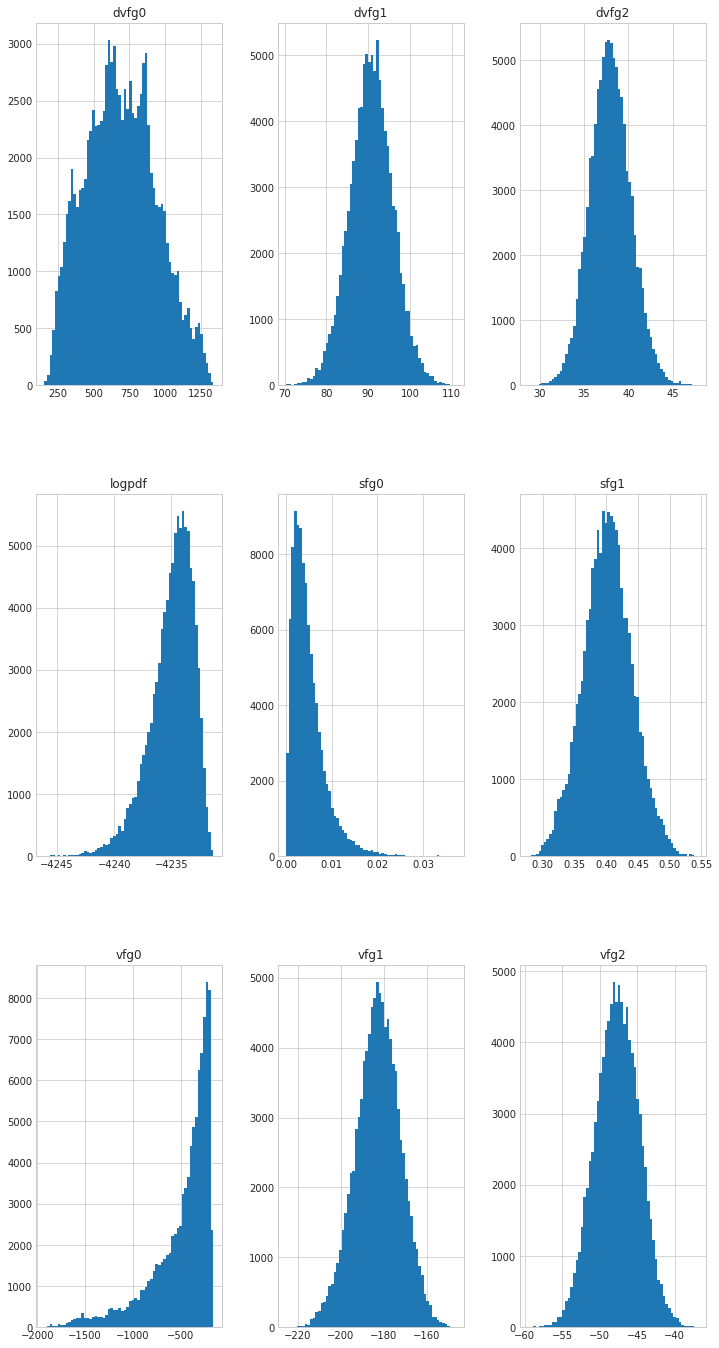

In [416]:
display(gen_cont.to_DataFrame()[600000:700000].describe())
gen_cont.to_DataFrame()[600000:700000].hist(bins=64,figsize=(12,24))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7856e13ac8>,
      dtype=object)

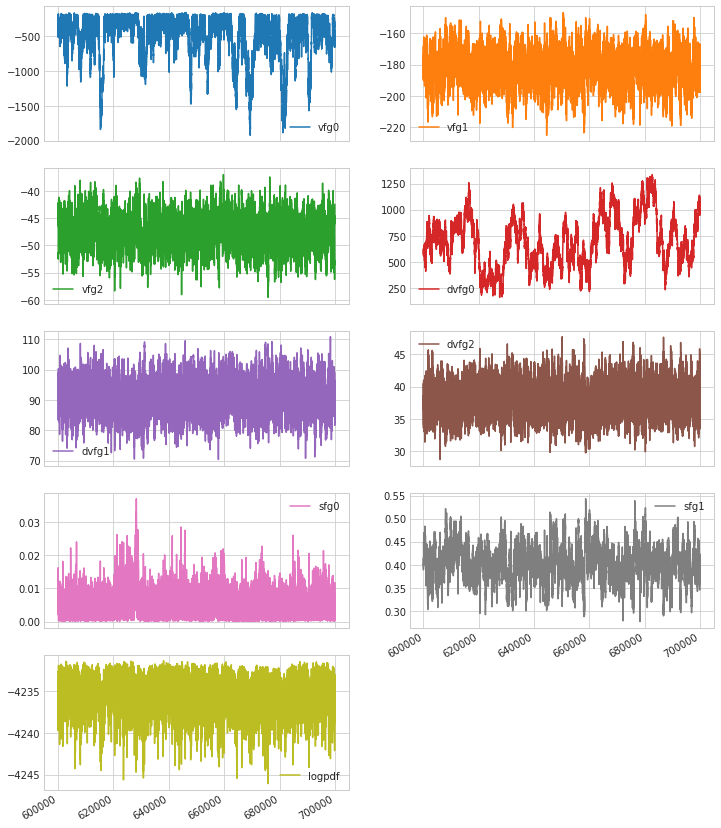

In [414]:
gen_cont.to_DataFrame()[600000:700000].plot(subplots=True,figsize=(12,16),layout=(5,2))

In [405]:
argmax_full = gen_cont.to_DataFrame().sort_values(by="logpdf").iloc[-1]
argmax_last = gen_cont.to_DataFrame()[-100000:].sort_values(by="logpdf").iloc[-1]
display(argmax_full)
display(argmax_last)
argmax_2gaussian = argmax_last.copy()
argmax_2gaussian.sfg0 = 0
logpdf_2gaussian = loglikeli_cont(**argmax_2gaussian[:-1])
display(logpdf_2gaussian)
display(logpdf_2gaussian-argmax_2gaussian.logpdf)

vfg0      -211.752721
vfg1      -184.586121
vfg2       -48.624447
dvfg0      433.148727
dvfg1       91.070118
dvfg2       38.313904
sfg0         0.003492
sfg1         0.398879
logpdf   -4231.332385
Name: 638094, dtype: float64

vfg0     -6.907239e+05
vfg1     -1.840974e+02
vfg2     -4.949531e+01
dvfg0     2.246518e+06
dvfg1     8.959726e+01
dvfg2     3.967549e+01
sfg0      8.780452e-04
sfg1      3.773287e-01
logpdf   -4.240324e+03
Name: 1034323, dtype: float64

-4250.4913240399455

-10.167631974753021

vfg0    -211.752721
vfg1    -184.586121
vfg2     -48.624447
dvfg0    433.148727
dvfg1     91.070118
dvfg2     38.313904
sfg0       0.003492
sfg1       0.398879
Name: 638094, dtype: float64

(-400, 50)

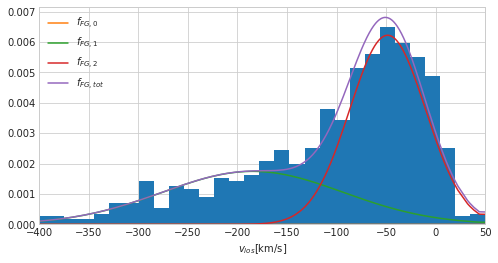

In [417]:
argmax_ = argmax_full[argmax_full.index[:-1]]
display(argmax_)
loglikeli_cont.fit_plot(**argmax_,figsize=(8,4))
plt.xlabel(r"$v_{los}$[km/s]")
plt.xlim((-400,50))

vfg0    -6.907239e+05
vfg1    -1.840974e+02
vfg2    -4.949531e+01
dvfg0    2.246518e+06
dvfg1    8.959726e+01
dvfg2    3.967549e+01
sfg0     8.780452e-04
sfg1     3.773287e-01
Name: 1034323, dtype: float64

(-400, 50)

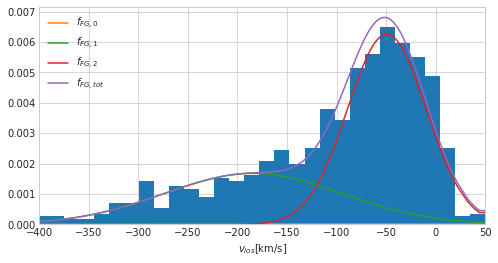

In [419]:
argmax_ = argmax_last[argmax_last.index[:-1]]
display(argmax_)
loglikeli_cont.fit_plot(**argmax_,figsize=(8,4))
plt.xlabel(r"$v_{los}$[km/s]")
plt.xlim((-400,50))

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contou

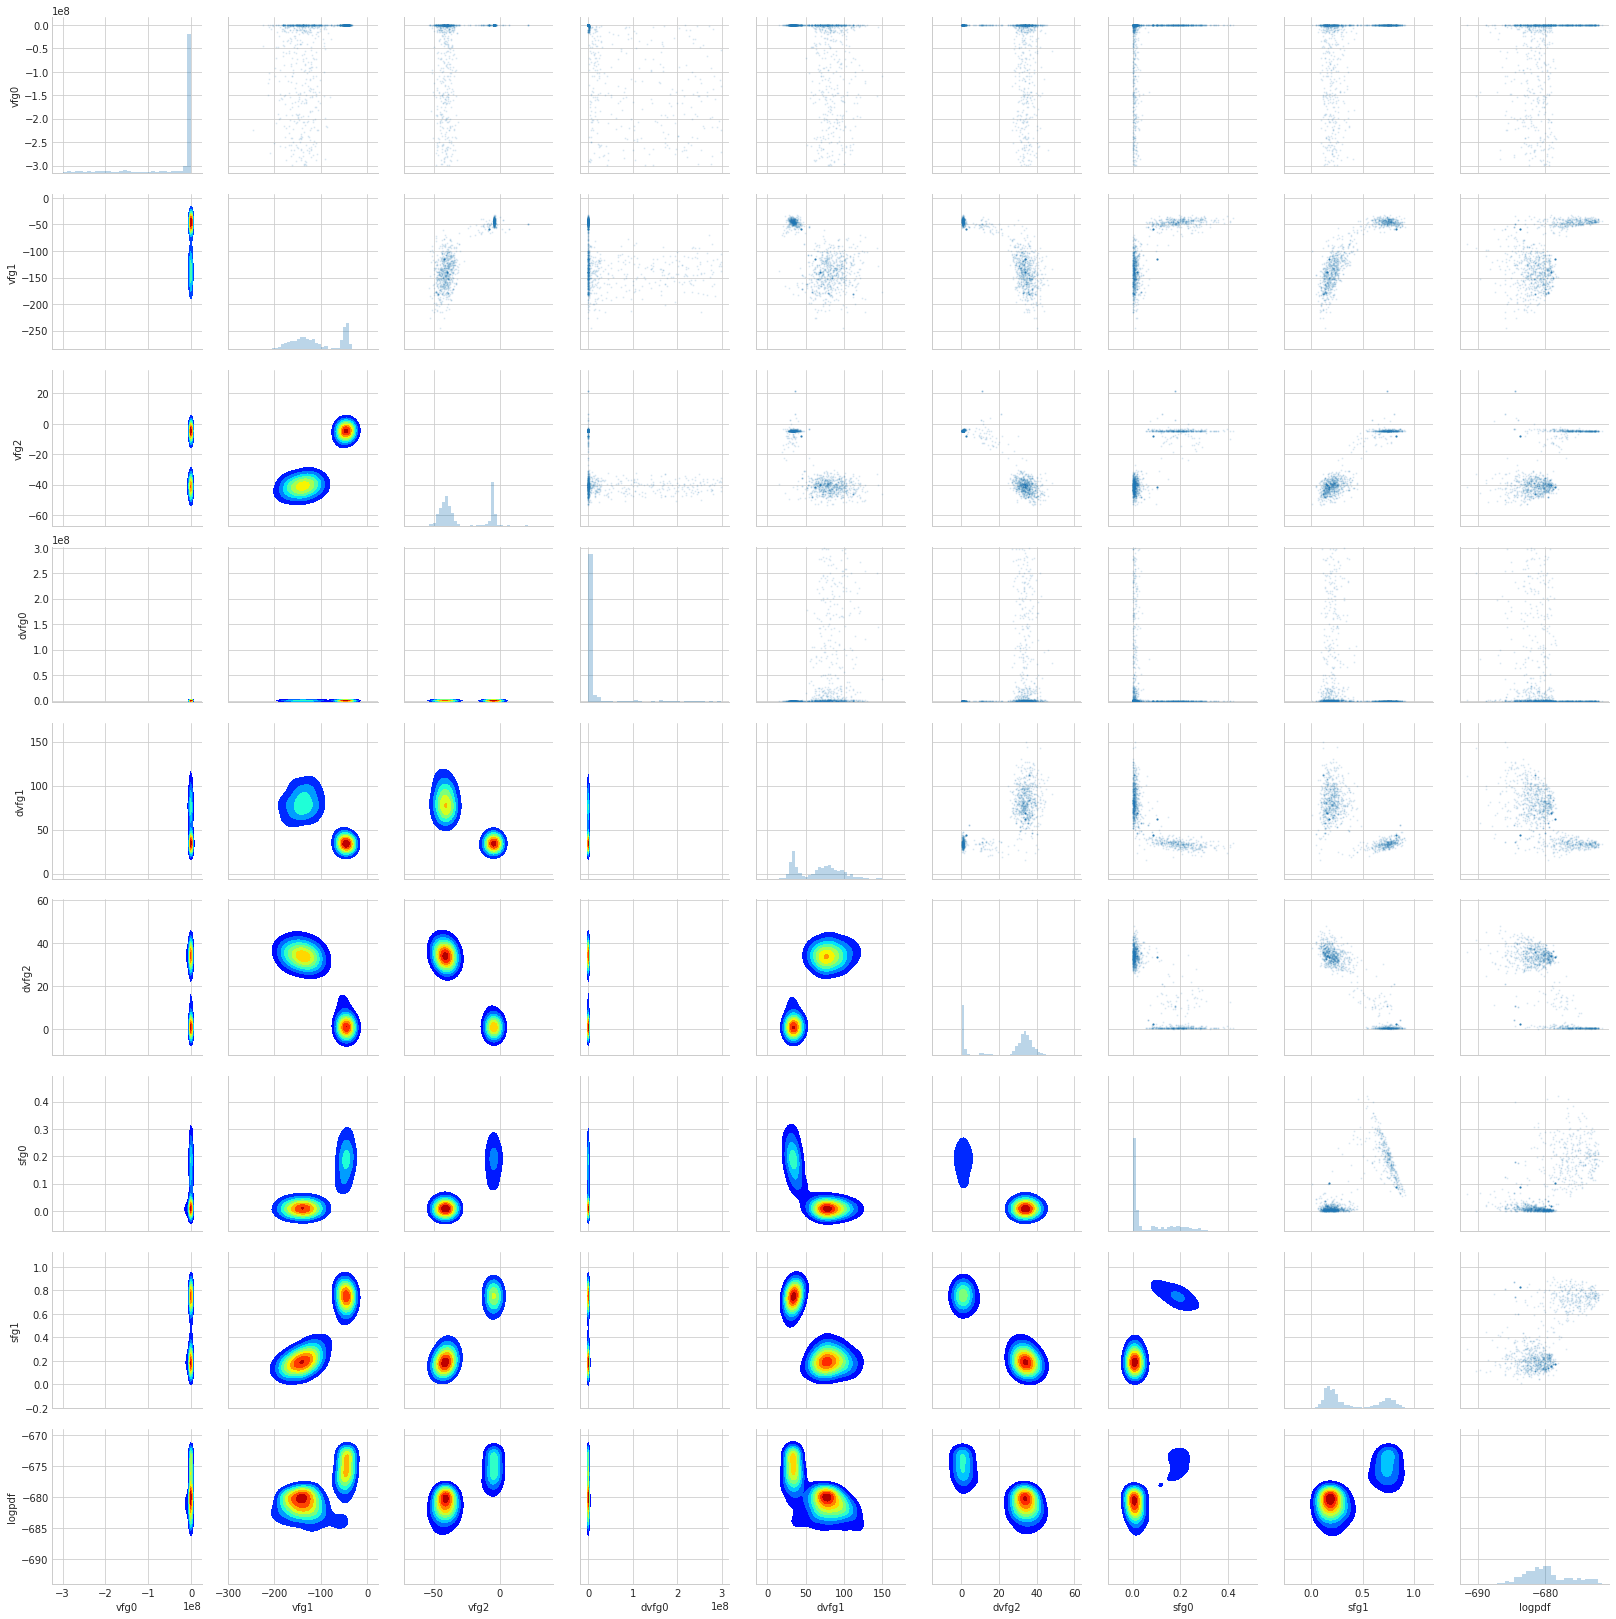

In [310]:
mypairplot(gen_cont.to_DataFrame()[::1000])

Note: The following warnings occur, but no problem.


/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/home/gomesu/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)


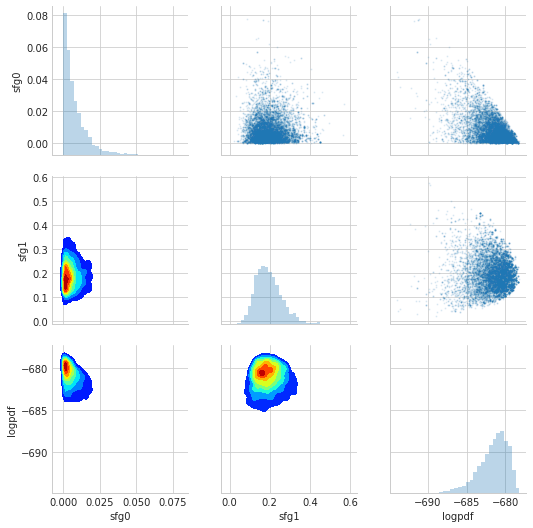

In [374]:
mypairplot(gen_cont.to_DataFrame()[-100000:][["sfg0","sfg1","logpdf"]][::10])

In [386]:
beta = 1/np.log(len(loglikeli_cont.vs))
display(1/beta)
bic_ = -gen_cont.to_DataFrame()["logpdf"].max() + (len(gen_cont.to_DataFrame().columns)-1)/2/beta
bic_

5.123963979403259

940.4712482227638

In [387]:
beta = 1/np.log(len(loglikeli_cont.vs))
bic_ = -logpdf_2gaussian + (3*2-1)/2/beta
bic_

940.3538598478767

In [420]:
SPECIFY_NAME = "spectroscopy_cont_refR-re-w-center_plummer_Rcont-830pc"
FNAME_BASE = "MCMCresult/MCMC{}_{}_{}.csv"
VERSION="v001"
gen_cont.to_csv(FNAME_BASE.format("",SPECIFY_NAME,VERSION))
gen_cont.to_csv(FNAME_BASE.format("log",SPECIFY_NAME,VERSION),output_log=True)

## Sig

In [443]:
loglikeli(**{
        "re":200, "odds":6.5,"dra0":0.0,"dde0":0.0,
        "log10_rs_pc":4, 'log10_rhos_Msunpc3':-2., 'a':2.5, 'b':7., 'g':0.5, 'mlog10_1manib':0., 
        'vmem':-200, 'vfg0':-250, 'vfg1':-200, 'vfg2':-50, 'dvfg0':50, 'dvfg1':50,'dvfg2':50,
        'sfg0':0.3,'sfg1':0.3
    })

-9936.69968599449

In [470]:
gen = MCgenerator.MCgenerator(
    args_logpdf_init={'re': 210.8790886646225,
 'odds': 5.2982575815642345,
 'dra0': 0.005337935688878717,
 'dde0': -0.0033726745373326246,
 'log10_rs_pc': 4.1619381528040655,
 'log10_rhos_Msunpc3': -2.301957325267942,
 'a': 2.031844678917404,
 'b': 7.208768126965503,
 'g': 0.7789918935056406,
 'mlog10_1manib': 0.13137034688494337,
 'vmem': -291.1260409103367,
 'vfg0': -76869035.16242182,
 'vfg1': -194.39098635398568,
 'vfg2': -45.71723707445756,
 'dvfg0': 212344481.70359486,
 'dvfg1': 86.72359279267742,
 'dvfg2': 41.88184628621562,
 'sfg0': 0.0049066062920015766,
 'sfg1': 0.41820060522777164
    },
    dargs_logpdf={
        "re":2.0,"odds":0.1,"dra0":0.01,"dde0":0.01,
        "log10_rs_pc":0.1,'log10_rhos_Msunpc3':0.1, 'a':0.1, 'b':0.1, 'g':0.1, 'mlog10_1manib':0.1, 
        'vmem':1, 'vfg0':1e8, 'vfg1':10, 'vfg2':1, 'dvfg0':1e8, 'dvfg1':2,'dvfg2':1,
        'sfg0':1e-3,'sfg1':0.02
    },
    logpdf_func=loglikeli
)

initialization of MCgenerator start.
function loaded.
logpdf_initialization completed.
Data chains are initialized.
MCparameters are initialized.


In [464]:
Nstep_init = 500
gen.generate(Nstep_init)

MCgeneration start.
options: {}
2.200% completed... acceptance rate: 36.36%
7.200% completed... acceptance rate: 16.67%
9.400% completed... acceptance rate: 14.89%
15.800% completed... acceptance rate: 8.86%
21.200% completed... acceptance rate: 8.49%
23.000% completed... acceptance rate: 8.70%
25.600% completed... acceptance rate: 7.81%
27.600% completed... acceptance rate: 7.97%
31.400% completed... acceptance rate: 8.28%
33.600% completed... acceptance rate: 7.74%
36.800% completed... acceptance rate: 7.07%
40.200% completed... acceptance rate: 6.47%
44.800% completed... acceptance rate: 6.25%
47.400% completed... acceptance rate: 5.91%
49.400% completed... acceptance rate: 5.67%
51.800% completed... acceptance rate: 5.41%
54.200% completed... acceptance rate: 5.54%
55.600% completed... acceptance rate: 5.40%
58.400% completed... acceptance rate: 5.48%
61.000% completed... acceptance rate: 5.57%
63.800% completed... acceptance rate: 5.33%
65.400% completed... acceptance rate: 5.20%


In [56]:
gen.to_DataFrame().plot(subplots=True,figsize=(8,12),layout=(8,3))
display(gen.to_DataFrame(output_log=True))
display(gen.to_DataFrame().describe())
display(gen.to_DataFrame().iloc[-1].to_dict())

NameError: name 'gen' is not defined

In [ ]:
gen.generate_tuned([2000]*4)

MCgeneration start.
options: {}
0.550% completed... acceptance rate: 9.09%
1.400% completed... acceptance rate: 3.57%
2.000% completed... acceptance rate: 2.50%
2.600% completed... acceptance rate: 1.92%
3.600% completed... acceptance rate: 2.78%
4.250% completed... acceptance rate: 3.53%
4.850% completed... acceptance rate: 5.15%
5.600% completed... acceptance rate: 4.46%
6.150% completed... acceptance rate: 5.69%
6.500% completed... acceptance rate: 5.38%
7.200% completed... acceptance rate: 4.86%
7.800% completed... acceptance rate: 4.49%
8.400% completed... acceptance rate: 4.76%
8.800% completed... acceptance rate: 5.11%
10.150% completed... acceptance rate: 4.93%
12.100% completed... acceptance rate: 4.13%
13.600% completed... acceptance rate: 3.68%
14.950% completed... acceptance rate: 3.34%
17.400% completed... acceptance rate: 2.87%
18.850% completed... acceptance rate: 2.92%
20.300% completed... acceptance rate: 2.71%
20.850% completed... acceptance rate: 2.88%
21.350% comple

11.900% completed... acceptance rate: 2.10%
12.600% completed... acceptance rate: 1.98%
13.150% completed... acceptance rate: 1.90%
13.600% completed... acceptance rate: 1.84%
14.050% completed... acceptance rate: 1.78%
14.650% completed... acceptance rate: 1.71%
15.050% completed... acceptance rate: 1.66%
15.700% completed... acceptance rate: 1.59%
16.150% completed... acceptance rate: 1.55%
16.500% completed... acceptance rate: 1.52%
17.050% completed... acceptance rate: 1.47%
17.550% completed... acceptance rate: 1.42%
18.000% completed... acceptance rate: 1.39%
18.650% completed... acceptance rate: 1.34%
19.350% completed... acceptance rate: 1.29%
19.700% completed... acceptance rate: 1.27%
20.300% completed... acceptance rate: 1.23%
20.950% completed... acceptance rate: 1.43%
21.650% completed... acceptance rate: 1.62%
22.750% completed... acceptance rate: 1.54%
23.800% completed... acceptance rate: 1.47%
24.500% completed... acceptance rate: 1.43%
25.450% completed... acceptance 

In [ ]:
gen.to_DataFrame()[:].plot(subplots=True)

In [ ]:
gen.options["push_time"] = 30
gen.generate(200000)

## results

In [ ]:
result_df = gen.to_DataFrame()
resultlog_df = gen.to_DataFrame(output_log=True)
resultlog_df

if you already done the calculation, load the result below.

In [ ]:
#result_df = pd.read_csv("MCMCresult/MCMC_refR-re-w-center_v001.csv")
#resultlog_df = pd.read_csv("MCMCresult/MCMClog_refR-re-w-center_v001.csv")

In [ ]:
ploted_stepset = 1
last_MCMC_steps = np.sum(resultlog_df.iter_num.values[-ploted_stepset:])
print("print last {} steps".format(last_MCMC_steps))
#result_df["re[deg]"] = np.rad2deg(result_df.re/draco_prop.DIST)
result_df[-last_MCMC_steps:].hist(bins=64,figsize=(12,6))

In [ ]:
mypairplot(result_df[-last_MCMC_steps::50])
#mypairplot(result_df[-lastMCMCsteps])

In [ ]:
stats = result_df[-last_MCMC_steps:].describe(percentiles=(0.16,0.5,0.84))
stats

In [ ]:
plots_likelis = pd.DataFrame()
#plots_likelis["R"] = Rs # ideally loglikeli.R but approzimately here we use Rs
plots_likelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"])
plots_likelis["prob"] = np.exp(np.log(2*np.pi*plots_likelis.R)+loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"])))
plots_likelis = plots_likelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_likelis[::].plot(x="R",y="prob",ax=ax,figsize=(12,6))
display(plots_likelis[::].hist("R",bins=32,density=True,alpha=0.3,ax=ax))

In [ ]:
plots_loglikelis = pd.DataFrame()
plots_loglikelis["R"] = loglikeli.Rs(dra0=stats.dra0.loc["50%"],dde0=stats.dde0.loc["50%"]) # ideally loglikeli.R but approzimately here we use Rs
plots_loglikelis["loglikeli"] = loglikeli.loglikelis(**(stats[["re","n","odds","dra0","dde0"]].loc["50%"]))
plots_loglikelis = plots_loglikelis.sort_values(by="R")

fig,ax = plt.subplots()
plots_loglikelis[::].plot(x="R",y="loglikeli",ax=ax,figsize=(12,6))

## export

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME
version = VERSION
result_df.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)

# WBIC calculation

In [ ]:
#update likelihood
class KI17_loglikelihood_mod:
    def __init__(self,dRAs,dDEs,beta=1):
        self.dRAs = dRAs
        self.dDEs = dDEs
        self.RoI_R = np.max(self.Rs(0,0)) # use Rs.max as the RoI
        self.beta = beta
        print(Rs.describe())
        print("beta: {}".format(self.beta)) if beta != 1 else None
        self.mem = dSph_model.plummer_model(re_pc=100)
        self.fg = dSph_model.uniform2d_model(Rmax_pc=self.RoI_R)

    def Rs(self,dra0,dde0):
        return coord.projected_distance(
            dist=DIST,
            ra_center = RA0+dra0,
            de_center = DE0+dde0,
            ra = RA0+self.dRAs,
            de = DE0+self.dDEs,
            dtype="deg")
        
    def __call__(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            return np.sum(self.loglikelis(re,odds,dra0,dde0))
    def loglikelis(self,re,odds,dra0,dde0):
        if re<0 or odds<0:
            return -np.inf
        else:
            mem,fg = self.mem,self.fg
            mem.update({"re_pc":re})
            ref_R = re
            
            C1 = 1/mem.cdf_R(self.RoI_R)
            C0 = fg.density_2d(self.RoI_R) # fg.density_2d returns constant for arbitrary input
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1 + C0)
            #s = C0/(sigmafg*mem.density_2d(self.Rs)*C1)
            s = 1/(1+ 1/odds * mem.density_2d(ref_R)/mem.mean_density_2d(self.RoI_R))
            
            arg_proj_dist_deg = {
                "ra":self.dRAs+RA0,"de":self.dDEs+DE0,
                "ra_center":RA0+dra0,"de_center":DE0+dde0
            }
            Rs = coord.projected_distance(dist=DIST,**arg_proj_dist_deg,dtype="deg")
            ret = np.log(s*C1*mem.density_2d(Rs)+(1-s)*C0)

            return self.beta * ret


In [ ]:
loglikeli_wbic = KI17_loglikelihood_mod(dRAs=df_deg.x,dDEs=df_deg.y,beta=1/np.log(len(df_deg)))

In [ ]:
gen_wbic = MCgenerator.MCgenerator(
    args_logpdf_init={"re":180,"n":0.8,"odds":6.5,"dra0":0.0,"dde0":0.0},
    dargs_logpdf={"re":5.0,"n":0.1,"odds":0.5,"dra0":0.01,"dde0":0.01},
    logpdf_func=loglikeli_wbic
)

In [ ]:
gen_wbic.generate(5000)

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate_tuned((5000,5000,5000))

In [ ]:
gen_wbic.to_DataFrame().plot(subplots=True)

In [ ]:
gen_wbic.generate(100000)

In [ ]:
df_wbic = gen_wbic.to_DataFrame()[-100000:]
df_wbiclog = gen_wbic.to_DataFrame(output_log=True)
mypairplot(df_wbic[::20])

In [ ]:
wbic = -df_wbic.logpdf.mean()/loglikeli_wbic.beta
bic = -gen.to_DataFrame()[-100000:].logpdf.max() + len(gen.args_logpdf_init)/loglikeli_wbic.beta /2
print(" BIC:{}\nWBIC:{}".format(bic,wbic))

In [ ]:
fname = FNAME_BASE
specify_name = SPECIFY_NAME+"_wbic"
version = VERSION
df_wbic.to_csv(fname.format("",specify_name,version),index=None)
resultlog_df.to_csv(fname.format("log",specify_name,version),index=None)